In [35]:
import torch
import torch.nn as nn
from typing import List

class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Classifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        """Classifier network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int):
        """Domain critic network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [36]:
from typing import Optional, Tuple
import numpy as np
from torch.utils.data import DataLoader
from tqdm.notebook import trange

class WDGRL:
    def __init__(
            self,
            input_dim: int = 2, 
            hidden_dims: List[int] = [20],
            discriminator: bool = True,
            num_classes: Optional[int] = 2,
            _gamma: float = 0.1, # Gradient penalty weight 
            _lambda: float = 0.1, # Coefficient controls the balance between discriminative and transferable feature learning
            _lr_domain_critic: float = 1e-2, # Learning rate for the domain critic parameter
            _lr_feature_extractor: float = 1e-2, # Learning rate for the feature extractor (and classifier parameter if discriminator is True) 
            device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
            random_seed: Optional[int] = 0
    ):
        if random_seed is not None:
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)

        self.device = device
        self._gamma = _gamma
        self._lambda = _lambda

        # Initialize networks
        self.feature_extractor = Generator(input_dim, hidden_dims).to(device)
        if discriminator:
            self.discriminator = Classifier(hidden_dims[-1], num_classes).to(device)
        self.domain_critic = Critic(hidden_dims[-1]).to(device)

        # Initialize optimizers
        if discriminator:
            self.discriminator_optimizer = torch.optim.Adam(list(self.discriminator.parameters())+list(self.feature_extractor.parameters()), lr=_lr_feature_extractor)
        self.domain_critic_optimizer = torch.optim.Adam(self.domain_critic.parameters(), lr=_lr_domain_critic)

        # Initialize loss functions
        if discriminator:
            self.classification_criterion = nn.CrossEntropyLoss()

    def compute_gradient_penalty(self, real_data: torch.Tensor, fake_data: torch.Tensor) -> torch.Tensor:
        """Compute gradient penalty."""
            
        alpha = torch.rand(real_data.size(0), 1).to(self.device)
        interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
        
        # Domain critic outputs
        dc_output = self.domain_critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=dc_output,
            inputs=interpolates,
            grad_outputs=torch.ones_like(dc_output).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> List[float]:
        """Evaluate accuracy."""
        self.feature_extractor.eval()
        self.discriminator.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        for data, labels in data_loader:
            data, labels = data.to(self.device), labels.to(self.device)
            features = self.feature_extractor(data)
            logits = self.discriminator(features)
            softmax = nn.Softmax(dim=1)
            loss = self.classification_criterion(logits, labels)
            total_loss += loss.item()
            _, preds = torch.max(softmax(logits), 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        return total_loss / len(data_loader), correct / total
    
    @torch.no_grad()
    def critic_score(self, data_loader: DataLoader) -> float:
        """Compute domain critic outputs."""
        self.feature_extractor.eval()
        self.domain_critic.eval()
        data = data_loader.dataset.tensors[0].to(self.device)
        features = self.feature_extractor(data)
        return self.domain_critic(features).mean().item()

    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        """Training WDGRL."""
        self.feature_extractor.train()
        self.discriminator.train()
        self.domain_critic.train()
        dc_losses = []
        dis_losses = []
        total_losses = []
        source_losses, source_accuracies = [], []
        target_losses, target_accuracies = [], []
        source_critic_scores, target_critic_scores = [], []
        for epoch in trange(num_epochs, desc='Epoch'):
            epoch_dc_loss = 0
            epoch_dis_loss = 0
            epoch_total_loss = 0
            for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
                source_data, source_labels = source_data.to(self.device), source_labels.to(self.device)
                target_data = target_data.to(self.device)

                # Train domain critic
                for __ in range(dc_iter):
                    self.domain_critic_optimizer.zero_grad()

                    with torch.no_grad():
                        source_features = self.feature_extractor(source_data)
                        target_features = self.feature_extractor(target_data)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.domain_critic(source_features)
                    dc_target = self.domain_critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self._gamma * gradient_penalty
                    dc_loss.backward()
                    self.domain_critic_optimizer.step()
            
                # Train feature extractor and classifier
                self.discriminator_optimizer.zero_grad()
                source_features = self.feature_extractor(source_data)
        
                # Discriminator loss
                source_logits = self.discriminator(source_features)
                dis_loss = self.classification_criterion(source_logits, source_labels)

                # Compute empirical Wasserstein distance
                target_features = self.feature_extractor(target_data)
                dc_source = self.domain_critic(source_features)
                dc_target = self.domain_critic(target_features)
                wasserstein_distance = dc_source.mean() - dc_target.mean()
            
                # Total loss
                total_loss = dis_loss + self._lambda * wasserstein_distance
                total_loss.backward()  
                self.discriminator_optimizer.step()
                
                with torch.no_grad():
                    epoch_dis_loss += dis_loss.item()
                    epoch_dc_loss += wasserstein_distance.item()
                    epoch_total_loss += total_loss.item()

            dc_losses.append(epoch_dc_loss / len(source_loader))
            dis_losses.append(epoch_dis_loss / len(source_loader))
            total_losses.append(epoch_total_loss / len(source_loader))
            source_critic_scores.append(self.critic_score(source_loader))
            target_critic_scores.append(self.critic_score(target_loader))
            source_loss, source_accuracy = self.evaluate(source_loader)
            target_loss, target_accuracy = self.evaluate(target_loader)
            source_losses.append(source_loss)
            source_accuracies.append(source_accuracy)
            target_losses.append(target_loss)
            target_accuracies.append(target_accuracy)
        return dc_losses, dis_losses, total_losses, source_critic_scores, target_critic_scores, source_losses, source_accuracies, target_losses, target_accuracies

    @torch.no_grad()
    def predict(self, data: torch.Tensor) -> torch.Tensor:
        """Predict."""
        self.feature_extractor.eval()
        self.discriminator.eval()
        features = self.feature_extractor(data)
        logits = self.discriminator(features)
        softmax = nn.Softmax(dim=1)
        _, preds = torch.max(softmax(logits), 1)
        return preds
    
    @torch.no_grad()
    def extract_features(self, data: torch.Tensor) -> torch.Tensor:
        """Extract features."""
        self.feature_extractor.eval()
        return self.feature_extractor(data)

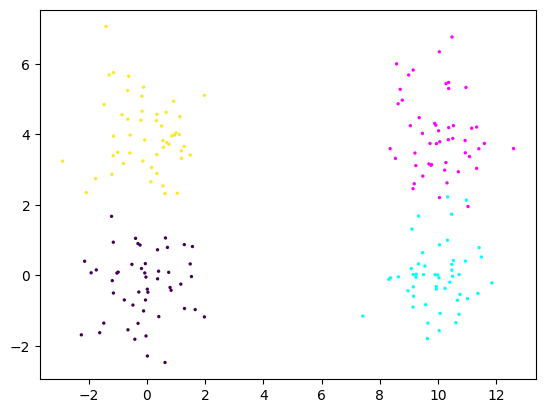

In [37]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt = 100, 100

xs, ys = make_blobs(ns, centers=[[0, 0], [0, 4]], cluster_std=1)
xt, yt = make_blobs(nt, centers=[[10, 0], [10, 4]], cluster_std=1)

plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], xt[:, 1], c=yt, cmap='cool', s=2)
plt.show()

In [38]:
# Convert to PyTorch tensors
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

In [39]:
from torch.utils.data import DataLoader, TensorDataset 
source_dataset = TensorDataset(xs, ys)
target_dataset = TensorDataset(xt, yt)
batch_size = 32
source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)

In [40]:
model = WDGRL()
num_epochs = 50
dc_losses, dis_losses, total_losses, source_critic_scores, target_critic_scores, source_losses, source_accuracies, target_losses, target_accuracies = model.train(source_loader, target_loader, num_epochs=num_epochs, dc_iter=200)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

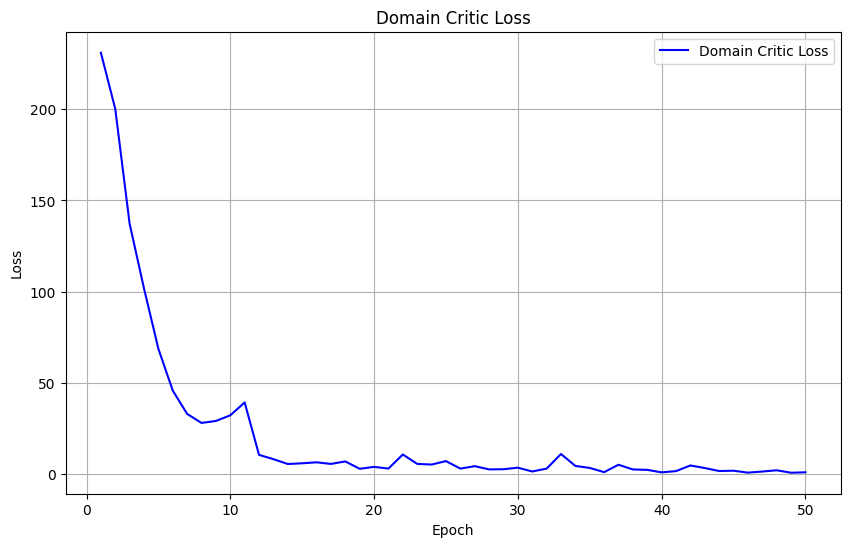

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), dc_losses, 'b-', label='Domain Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Critic Loss')
plt.legend()
plt.grid(True)
plt.show()

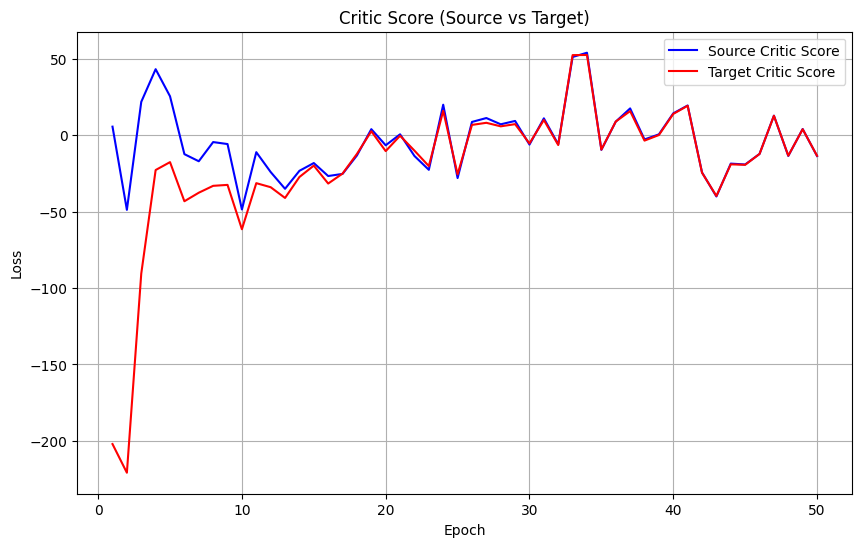

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), source_critic_scores, 'b-', label='Source Critic Score')
plt.plot(range(1, num_epochs+1), target_critic_scores, 'r-', label='Target Critic Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Critic Score (Source vs Target)')
plt.legend()
plt.grid(True)
plt.show()

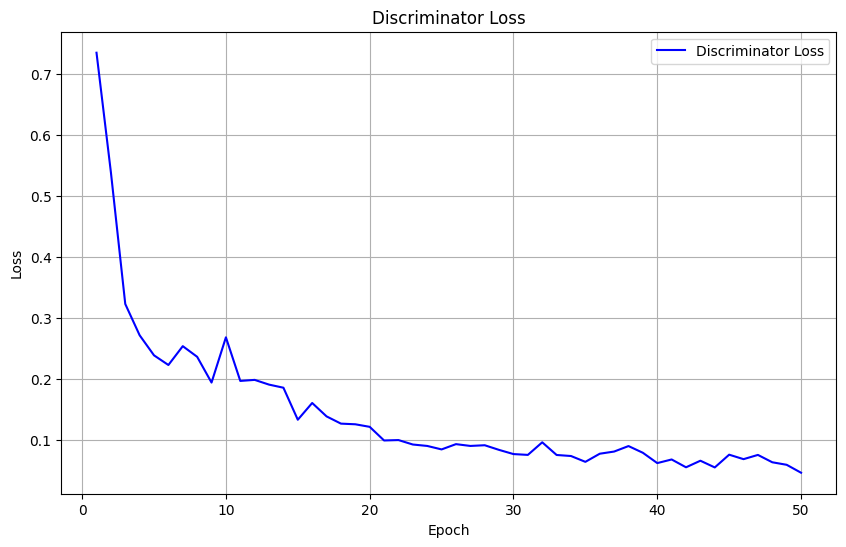

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), dis_losses, 'b-', label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.grid(True)
plt.show()

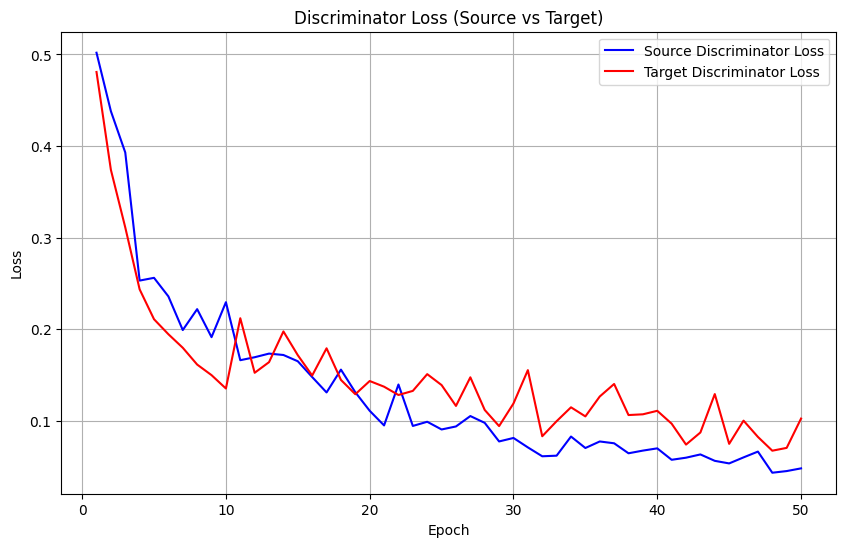

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), source_losses, 'b-', label='Source Discriminator Loss')
plt.plot(range(1, num_epochs+1), target_losses, 'r-', label='Target Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss (Source vs Target)')
plt.legend()
plt.grid(True)
plt.show()

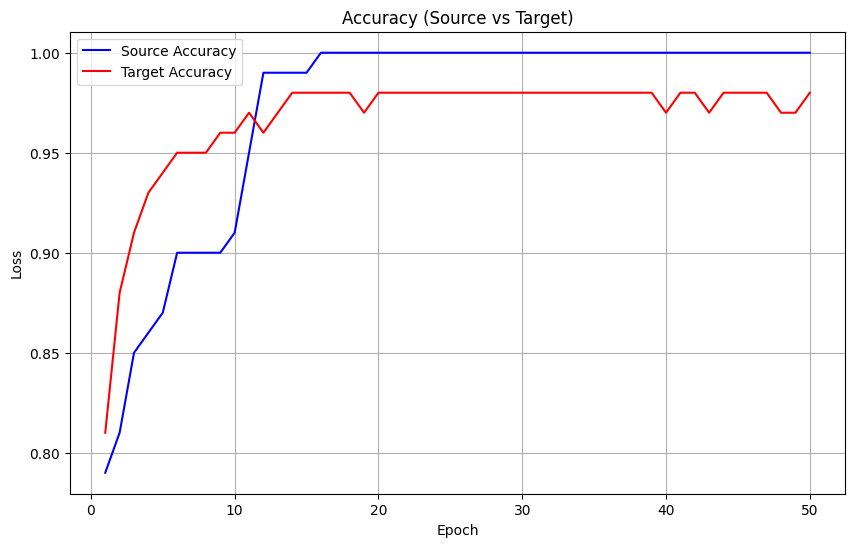

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), source_accuracies, 'b-', label='Source Accuracy')
plt.plot(range(1, num_epochs+1), target_accuracies, 'r-', label='Target Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy (Source vs Target)')
plt.legend()
plt.grid(True)
plt.show()

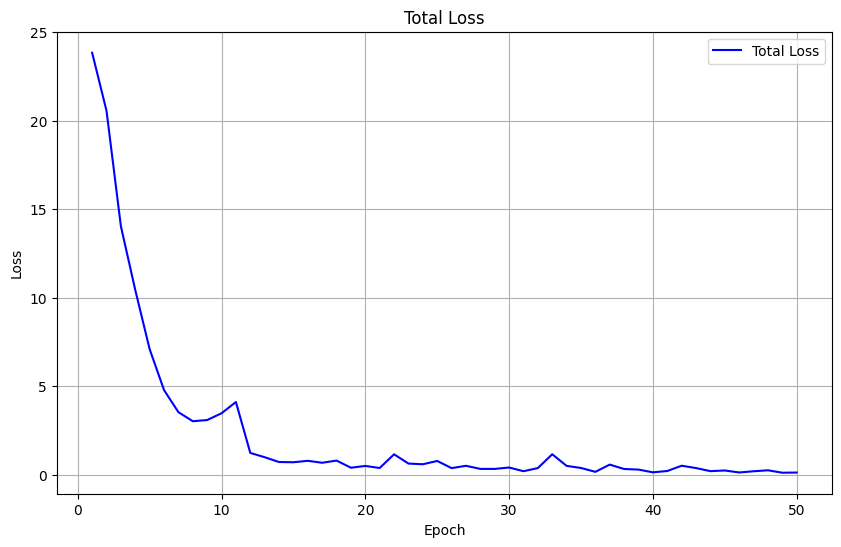

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), total_losses, 'b-', label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
torch.save(model, 'wdgrl.pth')